In [50]:
# import os
from pathlib import Path
import numpy as np
import pandas as pd
# from PIL import Image
from matplotlib import pyplot as plt
# import seaborn as sns
from astropy.units import imperial
from gwpy.timeseries import TimeSeries
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython.display import display
from sklearn import model_selection

# Load Data

In [2]:
# Following load code adapted from:
#  https://www.kaggle.com/xuzongniubi/g2net-efficientnet-b7-baseline-training

train_meta = pd.read_csv('../../data/training_labels.csv')
test_meta = pd.read_csv('../../data/sample_submission.csv')

def get_train_file_path(image_id):
    return "../../data/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "../../data/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train_meta['file_path'] = train_meta['id'].apply(get_train_file_path)
test_meta['file_path'] = test_meta['id'].apply(get_test_file_path)

label_dict = pd.Series(train_meta.target.values,index=train_meta.id).to_dict()

# Make Spectrograms

In [3]:
def MinMaxNorm(img):
    # Use min-max normalization to scale all pixels to values between 0 and 1.
    scaled = np.zeros(img.shape)
    for i in range(img.shape[2]):
        scaled[:, :, i] = (img[:, :, i] - np.min(img[:, :, i])) / (np.max(img[:, :, i]) - np.min(img[:, :, i]))
        
    return scaled

def MakeSpectrograms(data, method='channel', size=None, normalize=True, frange=(30, 500), qrange=(100, 110)):
    # NOTE: Only 'channel' method is implemented at the moment.
    
    for i in range(len(data)):
        tseries0 = TimeSeries(data[i, :, 0], sample_rate=2048)
        tseries1 = TimeSeries(data[i, :, 1], sample_rate=2048, t0=2)
        tseries2 = TimeSeries(data[i, :, 2], sample_rate=2048, t0=4)

        qt0 = tseries0.q_transform(frange=frange, qrange=qrange)
        qt1 = tseries1.q_transform(frange=frange, qrange=qrange)
        qt2 = tseries2.q_transform(frange=frange, qrange=qrange)

        temp = np.stack((qt0.value.tolist(), qt1.value.tolist(), qt2.value.tolist()), axis=-1)
        
        if (size is not None and len(size) == 2):
            temp2 = tf.image.resize(temp, size, preserve_aspect_ratio=True)

            # If on the first iteration, create an array to hold the data, now that we know the size.
            if (i == 0):
                qt = np.zeros((data.shape[0], temp2.shape[0], temp2.shape[1], 3))
                
            if (normalize):
                qt[i] = MinMaxNorm(temp2)
            else:
                qt[i] = temp2
            
        else:
            if (i == 0):
                qt = np.zeros((data.shape[0], temp.shape[0], temp.shape[1], 3))
            
            if (normalize):
                qt[i] = MinMaxNorm(temp)
            else:
                qt[i] = temp

#     print(f'Type = {type(qt_channels)}, shape = {qt_channels.shape}')

    return qt

In [87]:
def SaveSpectrograms(ids, size):
#     if (data.shape[0] != len(ids)):
#         print('Data and id arrays must be the same length')
#         return 1
    
#     print(f'ids shape = {ids.shape}')
    
    for i in ids:
#         print(f'i = {i}')
        raw = np.load("../../data/train/{}/{}/{}/{}.npy".format(i[0], i[1], i[2], i)).T
        raw = raw[np.newaxis, :, :]
#         print("raw shape = {}".format(raw.shape))
        d = MakeSpectrograms(raw, size=size, normalize=True)
#         print('d shape = {}'.format(d.shape))
        path = "../../data_{}x{}/train/{}/{}/{}/".format(d.shape[1],
                d.shape[2], i[0], i[1], i[2])
        Path(path).mkdir(parents=True, exist_ok=True)
        np.save(path + "{}.npy".format(i), d[0])


In [88]:
SaveSpectrograms(train_meta['id'][:4000], (128, 128))

In [55]:
path = "../../data_{}x{}/train/{}/{}/{}/".format(128,
                120, ID[0], ID[1], ID[2])
Path(path).mkdir(parents=True, exist_ok=True)

In [56]:
ID = '00000e74ad'
X_raw = np.load("../../data/train/{}/{}/{}/{}.npy".format(ID[0], ID[1], ID[2], ID)).T
X_raw = X_raw[np.newaxis, :, :]
print(X_raw.shape)
X = MakeSpectrograms(X_raw, size=(128, 128), normalize=True)
print(X.shape)

# SaveSpectrograms(None, None)

(1, 4096, 3)
(1, 128, 120, 3)


In [48]:
foo = np.array([ID])
print(foo.shape)
for i in foo:
    print(i)

(1,)
00000e74ad


(128, 120, 3)


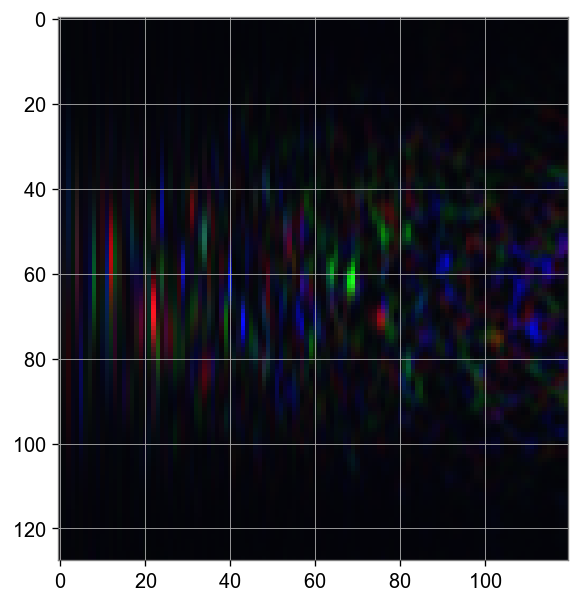

In [86]:
ID = train_meta['id'][1]
X = np.load("../../data_128x120/train/{}/{}/{}/{}.npy".format(ID[0], ID[1], ID[2], ID))
print(X.shape)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(X)

# Custom Keras Generator

From tutorial at: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
             n_classes=10, shuffle=True, resize_shape=None, apply_norm=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.resize_shape = resize_shape
        self.apply_norm = apply_norm
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load("../../data/train/{}/{}/{}/{}.npy".format(ID[0], ID[1], ID[2], ID)).T

            # Store class
            y[i] = self.labels[ID]

        # Not sure if I want this categorical transformation since I'm only doing
        # a binary classification, but I'll leave it for now.
        return X, y#tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X_raw, y = self.__data_generation(list_IDs_temp)
        
        X = MakeSpectrograms(X_raw, size=self.resize_shape, normalize=self.apply_norm)
        
#         self.out_shape = X[0].shape

        return X, y
    
    def GetOutputShape(self):
        ID = self.list_IDs[0]
        
        # Initialization
        X_raw = np.empty((1, *self.dim, self.n_channels))
        y = np.empty((1), dtype=int)

        # Generate data
        # Store sample
        X_raw[0,] = np.load("../../data/train/{}/{}/{}/{}.npy".format(ID[0], ID[1], ID[2], ID)).T

        X = MakeSpectrograms(X_raw, size=self.resize_shape, normalize=self.apply_norm)
        
        return X[0].shape

# Data Selection

#### Select some samples and split into training and validation sets

In [20]:
starting_sample = 4000
num_samples = 1000
end_idx = starting_sample + num_samples
id_list = train_meta['id'][starting_sample : end_idx].to_numpy()
label_list = [label_dict[k] for k in id_list]

X_train, X_val = model_selection.train_test_split(id_list,test_size=0.2, 
                                                    shuffle=True, random_state=42,
                                                    stratify=label_list)

params = {'dim': np.array([4096]),
          'batch_size': 100,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'resize_shape': (128, 128)}

train_gen = DataGenerator(X_train, label_dict, **params)
val_gen = DataGenerator(X_val, label_dict, **params)

data_shape = train_gen.GetOutputShape()

# Build CNN

Following tutorial here: https://www.tensorflow.org/tutorials/images/cnn

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Build Model

In [7]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(32, (12, 12), activation='relu', input_shape=(data_shape[0], data_shape[1], data_shape[2])))
model.add(layers.MaxPooling2D((8, 8)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# model.add(layers.Dense(2, activation='softmax'))
# model.add(layers.SoftMax())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 117, 109, 32)      13856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

### Compile and Train Model

In [21]:
model.compile(optimizer='sgd',#'adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='binary_crossentropy',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen,
                     epochs=20)

Epoch 1/20
8/8 [==============================] - 1252s 162s/step - loss: 0.6925 - accuracy: 0.5437 - val_loss: 0.6931 - val_accuracy: 0.4950
Epoch 2/20
8/8 [==============================] - 1123s 144s/step - loss: 0.6923 - accuracy: 0.5437 - val_loss: 0.6930 - val_accuracy: 0.5050
Epoch 3/20
8/8 [==============================] - 1118s 144s/step - loss: 0.6922 - accuracy: 0.5437 - val_loss: 0.6929 - val_accuracy: 0.4900
Epoch 4/20
8/8 [==============================] - 1118s 144s/step - loss: 0.6920 - accuracy: 0.5450 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 5/20
8/8 [==============================] - 1116s 144s/step - loss: 0.6919 - accuracy: 0.5450 - val_loss: 0.6928 - val_accuracy: 0.5100
Epoch 6/20
8/8 [==============================] - 1116s 144s/step - loss: 0.6918 - accuracy: 0.5175 - val_loss: 0.6927 - val_accuracy: 0.5100
Epoch 7/20
8/8 [==============================] - 1114s 143s/step - loss: 0.6918 - accuracy: 0.5188 - val_loss: 0.6927 - val_accuracy: 0.5050
Epoch 

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  MemoryError: Unable to allocate 7.17 MiB for an array with shape (1000, 940) and data type float64
Traceback (most recent call last):

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 961, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 837, in wrapped_generator
    for data in generator_fn():

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 963, in generator_fn
    yield x[i]

  File "C:\Users\antwo\AppData\Local\Temp/ipykernel_3944/3649004135.py", line 55, in __getitem__
    X = MakeSpectrograms(X_raw, size=self.resize_shape, normalize=self.apply_norm)

  File "C:\Users\antwo\AppData\Local\Temp/ipykernel_3944/3922272011.py", line 21, in MakeSpectrograms
    temp = np.stack((qt0.value.tolist(), qt1.value.tolist(), qt2.value.tolist()), axis=-1)

  File "<__array_function__ internals>", line 5, in stack

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\shape_base.py", line 421, in stack
    arrays = [asanyarray(arr) for arr in arrays]

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\shape_base.py", line 421, in <listcomp>
    arrays = [asanyarray(arr) for arr in arrays]

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_asarray.py", line 171, in asanyarray
    return array(a, dtype, copy=False, order=order, subok=True)

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 7.17 MiB for an array with shape (1000, 940) and data type float64


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_4]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  MemoryError: Unable to allocate 7.17 MiB for an array with shape (1000, 940) and data type float64
Traceback (most recent call last):

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 961, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 837, in wrapped_generator
    for data in generator_fn():

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 963, in generator_fn
    yield x[i]

  File "C:\Users\antwo\AppData\Local\Temp/ipykernel_3944/3649004135.py", line 55, in __getitem__
    X = MakeSpectrograms(X_raw, size=self.resize_shape, normalize=self.apply_norm)

  File "C:\Users\antwo\AppData\Local\Temp/ipykernel_3944/3922272011.py", line 21, in MakeSpectrograms
    temp = np.stack((qt0.value.tolist(), qt1.value.tolist(), qt2.value.tolist()), axis=-1)

  File "<__array_function__ internals>", line 5, in stack

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\shape_base.py", line 421, in stack
    arrays = [asanyarray(arr) for arr in arrays]

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\shape_base.py", line 421, in <listcomp>
    arrays = [asanyarray(arr) for arr in arrays]

  File "E:\Programs\anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_asarray.py", line 171, in asanyarray
    return array(a, dtype, copy=False, order=order, subok=True)

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 7.17 MiB for an array with shape (1000, 940) and data type float64


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_7781768]

Function call stack:
test_function -> test_function


In [ ]:
model.save('trained_5000')

### Evaluate Model

2/2 [==============================] - 229s 113s/step - loss: 0.6921 - accuracy: 0.5700
0.5699999928474426


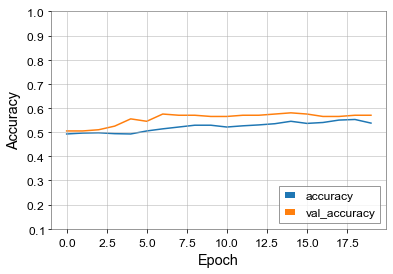

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_gen, verbose=1)

print(test_acc)

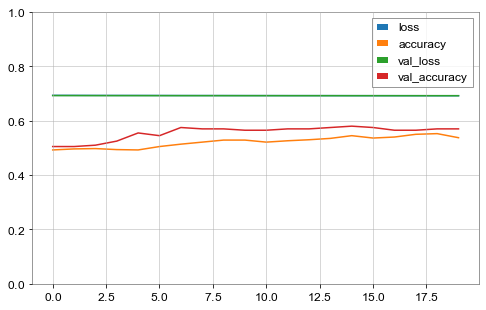

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig(\"keras_learning_curves_plot\")
plt.show()